In [6]:
import matplotlib.pyplot as plt
import numpy as np

from collections import defaultdict
from collections import Counter
import random
import sys
import pickle

sys.path.insert(0,'../decryption')
sys.path.insert(0,'../encryption')
sys.path.insert(0,'../dictionaries')

import encrypt
import decrypt
import alphabet
import frequency

In [2]:
# encryption module created by Ralph
' | '.join(dir(encrypt))

'ALPHABET | ALPHABET_SIZE | LETTER_POS_DICT | PROBABILITY_REPLACEMENT | TEST_BLANKS | TEST_M | __builtins__ | __cached__ | __doc__ | __file__ | __loader__ | __name__ | __package__ | __spec__ | char_key_mapping_from_key_mapping | encrypt | generate_key_mapping | main | np | random'

In [3]:
# alphabet module created by Ralph
' | '.join(dir(alphabet))

'_ALPHABET | _ALPHABET_SIZE | _LETTER_TO_POS_DICT | __builtins__ | __cached__ | __doc__ | __file__ | __loader__ | __name__ | __package__ | __spec__ | get_alphabet | get_char_from_int | get_int_from_char | get_size | main'

In [4]:
# frequency module created by Ralph
' | '.join(dir(frequency))

'__builtins__ | __cached__ | __doc__ | __file__ | __loader__ | __name__ | __package__ | __spec__ | alphabet | bigram_frequency | bigram_get_next_frequency | bigram_get_previous_frequency | convert_char_array_to_dict | count_keys | defaultdict | duplicates | get_ordered_list_of_char_frequencies | get_word_frequency_statistics | get_words | main | n_gram_freq | np | print_bigram_frequency | process_bigram_dictionary | report_stats | statistics | word_count'

In [9]:
# simulation of problem
TEST_KEY_MAPPING = encrypt.generate_key_mapping()
TEST_CHAR_MAPPING = encrypt.char_key_mapping_from_key_mapping(TEST_KEY_MAPPING)

assert len(set(TEST_KEY_MAPPING)) == 27

TEST_PLAIN_TEXTS = []
with open('../dictionaries/official_dictionary_1_cleaned.txt','r') as f:
    content = f.readlines()
    for line in content:
        TEST_PLAIN_TEXTS.append(line.strip())

TEST_PROBABILITY = 0.2
ciphers = [encrypt.encrypt(msg,TEST_KEY_MAPPING,TEST_PROBABILITY) for msg in TEST_PLAIN_TEXTS]

# pick a random cipher and start working with it. (We should not know the original plain text)
r = random.randint(0,len(ciphers)-1)
cipher_txt = ciphers[r]
test_plain_text = TEST_PLAIN_TEXTS[r]

TEST_PLAIN_TEXTS[3] += ' '

In [16]:
# pre-processing plain text
freqs = [frequency.n_gram_freq(txt,1) for txt in TEST_PLAIN_TEXTS]
l = len(TEST_PLAIN_TEXTS[0])

In [17]:
# processing the cipher
c_freq = frequency.n_gram_freq(cipher_txt,1)
cl = len(cipher_txt)

# number of extra characters
diff = cl - l
print('diff',diff)

# approx probability
pr = (cl - l)/cl

sorted_c_freq = sorted(c_freq.items(),key = lambda a : -a[1])

diff 124


In [18]:
# confirming that the solution exists
for txt in TEST_PLAIN_TEXTS:
    if decrypt.test_candidate_mapping(TEST_CHAR_MAPPING,cipher_txt,txt,diff):
        print('solution detectable')
        break

solution detectable


In [19]:
def test_char_mapping(k_mapping):
    for txt in TEST_PLAIN_TEXTS:
        if decrypt.test_candidate_mapping(k_mapping,cipher_txt,txt,diff):
            return txt
    return None

In [20]:
# processing the cipher
c_freq = frequency.n_gram_freq(cipher_txt,1)
cl = len(cipher_txt)

# number of extra characters
diff = cl - l

# approx probability
pr = (cl - l)/cl

sorted_c_freq = sorted(c_freq.items(),key = lambda a : -a[1])

In [21]:
# test strategy: for max_diff closest and greater than diff/27, test key mapping
diff_extractor = lambda a : a[0][1] - a[1][1]
min_idx = 0
min_max_diff = 1e10
for i,freq in enumerate(freqs):
    sorted_freq = sorted(freq.items(),key = lambda a : -a[1])
    max_diff_chars = max(zip(sorted_c_freq,sorted_freq),key = diff_extractor )
    max_diff = diff_extractor(max_diff_chars) # should be greater than diff/27 but not by much
    if max_diff<min_max_diff:
        min_max_diff = max_diff
        min_idx = i

print(min_idx == r)

True


In [22]:
# naive strategy: vary each frequency of each candidate text by upto diff and match sorted frequency counts
# then use confirmation function to check if guess is correct to eliminate corner cases

# time complexity for this O( comb(n+26,n) ) where n is number of random insertions. 
# Explanation: we are dividing each random character occurence among 27 bins.
# We can use this strategy if we have comb(n+26,n) is small enough

import math
math.comb(10+26,10)


254186856

In [23]:
# conclusion: for even small values of diff, we have to process too much. This isn't feasible

In [24]:
plain_txt = test_plain_text

In [25]:
# iterate over each plaintext and attempt to match corresponding characters
# if a previous mapping is violated, record the violation. If violation keeps occuring, update key mapping
# recalibrate violations based on key mapping update
# In the end, number of violations should be equal to number of random characters

guess = dict()
valid_ct = defaultdict(int) 
c_itr = p_itr = 0
r_ct = 0

INVALID_THRESH = 2

while p_itr < len(plain_txt) and c_itr<len(cipher_txt):
    p_chr = plain_txt[p_itr]
    c_chr = cipher_txt[c_itr]
    guess_chr = guess.get(p_chr)
    original_chr = TEST_CHAR_MAPPING[p_chr]
    
    print('p chr:',p_chr,'c chr:',c_chr,'guess:',guess_chr)
    print('actual:',original_chr)
    
    if guess_chr:
        # guess mapping present
        if guess_chr == cipher_txt[c_itr]:
            # we have a correct guess
            valid_ct[p_chr] += 1
            c_itr += 1
            p_itr += 1
        else:
            print('incorrect guess')
            # incorrect guess. either count as random char or remove mapping
            valid_ct[p_chr] -= 1
            if valid_ct[p_chr] < INVALID_THRESH:
                # delete guess
                del guess[p_chr]
                valid_ct[p_chr] = 1

                # update guess
                guess[p_chr] = cipher_txt[c_itr]

                c_itr += 1
                p_itr += 1
            else:
                # count as random char
                r_ct += 1
                c_itr += 1            
    else:
        # no guess found
        guess[p_chr] = cipher_txt[c_itr]
        valid_ct[p_chr] = 1
        c_itr += 1
        p_itr += 1

p chr: u c chr: b guess: None
actual: b
p chr: n c chr: d guess: None
actual: d
p chr: d c chr:   guess: None
actual: c
p chr: e c chr: c guess: None
actual: o
p chr: r c chr: o guess: None
actual: h
p chr: w c chr: h guess: None
actual: p
p chr: a c chr: p guess: None
actual: n
p chr: i c chr: y guess: None
actual: y
p chr: s c chr: n guess: None
actual: t
p chr: t c chr: y guess: None
actual:  
p chr: s c chr: t guess: n
actual: t
incorrect guess
p chr:   c chr:   guess: None
actual: f
p chr: w c chr: z guess: h
actual: p
incorrect guess
p chr: a c chr: t guess: p
actual: n
incorrect guess
p chr: y c chr: f guess: None
actual: x
p chr: f c chr: p guess: None
actual: e
p chr: a c chr: n guess: t
actual: n
incorrect guess
p chr: r c chr: n guess: o
actual: h
incorrect guess
p chr: i c chr: x guess: y
actual: y
incorrect guess
p chr: n c chr: e guess: d
actual: d
incorrect guess
p chr: g c chr:   guess: None
actual: w
p chr: s c chr: n guess: t
actual: t
incorrect guess
p chr:   c chr: 

p chr: e c chr: u guess: t
actual: o
incorrect guess
p chr:   c chr: q guess: o
actual: f
incorrect guess
p chr: c c chr: b guess: o
actual: q
incorrect guess
p chr: h c chr: i guess: u
actual: m
incorrect guess
p chr: u c chr: u guess: f
actual: b
incorrect guess
p chr: r c chr: h guess: o
actual: h
incorrect guess
p chr: l c chr: n guess: a
actual: v
incorrect guess
p chr:   c chr: d guess: q
actual: f
incorrect guess
p chr: k c chr: q guess: e
actual: z
incorrect guess
p chr: o c chr: p guess: o
actual: j
incorrect guess
p chr: l c chr: i guess: n
actual: v
incorrect guess
p chr: i c chr: o guess: u
actual: y
incorrect guess
p chr: n c chr: t guess: o
actual: d
incorrect guess
p chr: s c chr: f guess: d
actual: t
incorrect guess
p chr: k c chr: a guess: q
actual: z
incorrect guess
p chr: i c chr: h guess: o
actual: y
incorrect guess
p chr: e c chr: j guess: u
actual: o
incorrect guess
p chr: s c chr: v guess: f
actual: t
incorrect guess
p chr:   c chr: y guess: d
actual: f
incorrect

In [26]:
correct = True
for k,v in guess.items():
    if v != TEST_CHAR_MAPPING[k]:
        correct = False
print(correct)

False


In [27]:

def confirm(freq_p,freq_c,plain_txt):
    guess = dict()
    for p_chr,c_chr in zip(freq_p,freq_c):
        guess[p_chr[0]] = c_chr[0]
    if decrypt.test_candidate_mapping(guess,cipher_txt,plain_txt,diff):
        return plain_txt
    return None

In [28]:
guess = dict()
taken = [False for _ in c_freq]

LIM = 1
def backtrack(current,freq_p,freq_c,guess,plain_text):
    if current == len(freq_c):
        return confirm(freq_p,freq_c,plain_text)
    
    for i in range(current,min(len(freq_c)+LIM,len(freq_c))):
        if taken[i]: continue
        # swap i, current
        if i!=current: freq_p[i],freq_p[current] = freq_p[current],freq_p[i]
        taken[i] = True
        # backtrack
        ret = backtrack(current+1,freq_p,freq_c,guess,plain_text)
        if not ret is None: return ret
        # swap back
        if i!=current: freq_p[i],freq_p[current] = freq_p[current],freq_p[i]
        taken[i] = False
    

In [7]:
# # test distribution of extra random characters as compared to p
# vals = {i/100:[] for i in range(1,81)}

# for i in range(1,81):
#     p = i/100
#     for _ in range(1000):
#         txt = random.choice(TEST_PLAIN_TEXTS)
#         k_map = encrypt.generate_key_mapping()
#         cfr = encrypt.encrypt(txt,k_map,p)
#         vals[p].append(len(cfr)-len(txt))
        
# # write vals
# with open('extra_random_dist.pickle', 'wb') as handle:
#     pickle.dump(vals, handle, protocol=pickle.HIGHEST_PROTOCOL)

# read vals
with open('extra_random_dist.pickle', 'rb') as handle:
    vals = pickle.load(handle)

In [8]:
xs = []
ys = []

for k,vs in vals.items():
    for v in vs:
        xs.append(v)
        ys.append(k)

In [1]:
import sklearn

In [2]:
sklearn.__version__

'1.0.2'

In [9]:
import numpy as np
from sklearn.linear_model import LinearRegression

X = np.array(xs).reshape(-1, 1)
y = np.array(ys)

reg = LinearRegression().fit(X, y)

In [10]:
reg.score(X, y)

0.8356217059146136

In [11]:
reg.intercept_

0.18707214397062388

In [12]:
reg.coef_

array([0.00042047])

In [13]:

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=6, include_bias=False)

In [14]:
X_poly = poly.fit_transform(X)

In [15]:
reg = LinearRegression().fit(X_poly, y)


In [16]:
reg.score(X_poly,y)

0.9774506178180561

In [17]:
reg.predict(X_poly)

array([0.10099232, 0.10084079, 0.10088024, ..., 0.75416538, 0.76121117,
       0.75791955])

In [18]:
np.array(2).reshape(-1,1)

array([[2]])

In [21]:
with open('p_hat_regressor.pickle', 'wb') as handle:
    pickle.dump(reg, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('p_hat_poly.pickle', 'wb') as handle:
    pickle.dump(poly, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
with open('p_hat_poly.pickle', 'rb') as handle:
    p_hat_poly = pickle.load(handle)

In [30]:
reg.predict(p_hat_poly.fit_transform(X))

array([0.10099232, 0.10084079, 0.10088024, ..., 0.75416538, 0.76121117,
       0.75791955])

In [52]:
y

array([0.01, 0.01, 0.01, ..., 0.8 , 0.8 , 0.8 ])

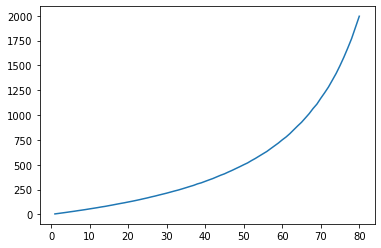

In [30]:
# mean vs random percentage
plt.plot(range(1,81),[np.mean(a[1]) for a in sorted(vals.items(),key = lambda a:a[0])])

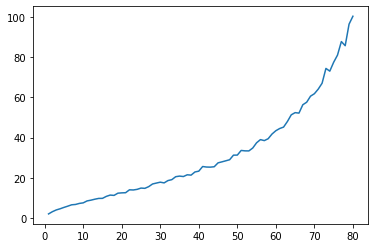

In [56]:
# std dev vs random percentage
plt.plot(range(1,81),[np.std(a[1]) for a in sorted(vals.items(),key = lambda a:a[0])])

In [4]:
spaces = []
for txt in TEST_PLAIN_TEXTS:
    spaces.append(Counter(txt)[' '])

In [5]:
spaces

[54, 53, 48, 50, 50]

In [6]:
500/49

10.204081632653061

In [7]:
15/500 * 2500

75.0

In [ ]:
# backtrack over a guess - word wise
# consider a word as cipher which at max accounts for 3% of the length of the cipher text
# choose most likely guesses first


In [65]:
# first and last letter frequencies in each plaintext

ctrs = []
for txt in TEST_PLAIN_TEXTS:
    ctr = defaultdict(int)
    for word in txt.split():
        ctr[word[0]] += 1
        if len(word) == 1: continue
        ctr[word[-1]] += 1
    ctrs.append(ctr)

In [93]:
print('letter frequencies\n')

for i,ctr in enumerate(ctrs):
    print(f'for plaintext {i+1}\n')
    mx = max(ctr.items(),key = lambda a:a[1])
    print('max frequency letter:',mx)
    
    mn = min(ctr.items(),key = lambda a:a[1])
    print('min frequency letter:',mn,'\n')

letter frequencies

for plaintext 1

max frequency letter: ('s', 24)
min frequency letter: ('f', 1) 

for plaintext 2

max frequency letter: ('s', 28)
min frequency letter: ('j', 1) 

for plaintext 3

max frequency letter: ('s', 17)
min frequency letter: ('z', 1) 

for plaintext 4

max frequency letter: ('s', 28)
min frequency letter: ('h', 1) 

for plaintext 5

max frequency letter: ('s', 22)
min frequency letter: ('f', 1) 



In [94]:
# vowel stats
print('vowel stats')
vowels = set(['a','e','i','o','u'])

for i,txt in enumerate(TEST_PLAIN_TEXTS):
    print(f'\nfor plaintext {i+1}\n')
    
    vowel_ctr = defaultdict(int)
    consonants = 0
    for c in txt:
        if c == ' ':continue
        if c in vowels: vowel_ctr[c] += 1
        else: consonants += 1
        
    total_vowels = sum([a[1] for a in vowel_ctr.items()])
    print('total vowels:',total_vowels)
    print('total consonants:',consonants)
    print('ratio:',round(consonants/total_vowels,3))
    print('vowel frequencies:',vowel_ctr)
        

vowel stats

for plaintext 1

total vowels: 161
total consonants: 285
ratio: 1.77
vowel frequencies: defaultdict(<class 'int'>, {'u': 22, 'e': 57, 'a': 30, 'i': 32, 'o': 20})

for plaintext 2

total vowels: 164
total consonants: 283
ratio: 1.726
vowel frequencies: defaultdict(<class 'int'>, {'o': 36, 'u': 15, 'e': 47, 'a': 33, 'i': 33})

for plaintext 3

total vowels: 167
total consonants: 285
ratio: 1.707
vowel frequencies: defaultdict(<class 'int'>, {'o': 32, 'e': 48, 'a': 29, 'i': 41, 'u': 17})

for plaintext 4

total vowels: 163
total consonants: 286
ratio: 1.755
vowel frequencies: defaultdict(<class 'int'>, {'e': 50, 'a': 37, 'u': 16, 'i': 41, 'o': 19})

for plaintext 5

total vowels: 170
total consonants: 280
ratio: 1.647
vowel frequencies: defaultdict(<class 'int'>, {'o': 25, 'u': 12, 'a': 45, 'e': 49, 'i': 39})


In [95]:
# bigram, trigram stats
print('bigram, trigram stats')

def n_gram_freq(n,txt):
    ngram_ctr = defaultdict(int)
    for word in txt.split():
        for i in range(len(word) - n + 1):
            ngram_ctr[word[i:i+n]] += 1
    
    mx = max(ngram_ctr.items(),key = lambda a:a[1])
    print(f'max frequency {n}gram:',mx)
    
    mn = min(ngram_ctr.items(),key = lambda a:a[1])
    print(f'min frequency {n}gram:',mn,'\n')

for i,txt in enumerate(TEST_PLAIN_TEXTS):
    print(f'\nfor plaintext {i+1}\n')
    n_gram_freq(2,txt)
    n_gram_freq(3,txt)
    

bigram, trigram stats

for plaintext 1

max frequency 2gram: ('er', 14)
min frequency 2gram: ('nd', 1) 

max frequency 3gram: ('ing', 4)
min frequency 3gram: ('und', 1) 


for plaintext 2

max frequency 2gram: ('er', 14)
min frequency 2gram: ('rh', 1) 

max frequency 3gram: ('ers', 5)
min frequency 3gram: ('rho', 1) 


for plaintext 3

max frequency 2gram: ('er', 13)
min frequency 2gram: ('yo', 1) 

max frequency 3gram: ('ers', 6)
min frequency 3gram: ('yor', 1) 


for plaintext 4

max frequency 2gram: ('er', 13)
min frequency 2gram: ('cy', 1) 

max frequency 3gram: ('ers', 7)
min frequency 3gram: ('cyg', 1) 


for plaintext 5

max frequency 2gram: ('er', 13)
min frequency 2gram: ('ov', 1) 

max frequency 3gram: ('ing', 6)
min frequency 3gram: ('ovu', 1) 



In [ ]:
# check some aggregate stats